In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
%load_ext memory_profiler

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np

import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re


sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [100]:
module = fc.eightb.preselection.t8btag_minmass
table.csv = 't8btag_minmass'

signal = ObjIter([Tree(fn) for fn in module.signal_list])
# signal = ObjIter([Tree(module.NMSSM_XYY_YToHH_8b_MX_1000_MY_450)])
# signal_asym = ObjIter([Tree(fc.eightb.preselection.NMSSM_XYY_YToHH_8b_MX_1000_MY_450)])
qcd = ObjIter([Tree(module.QCD_B_List)])
# qcd_asym = ObjIter([Tree(fc.eightb.preselection.QCD_B_List)])
ttbar = ObjIter([Tree(module.TTJets)])
# ttbar = ObjIter([])
# qcd = ObjIter([])

100%|██████████| 2/2 [00:01<00:00,  1.34it/s]


# Event Selection
## - Trigger applied | HLT_PFHT330PT30_QuadPFJet_75_60_45_40_TriplePFBTagDeepCSV_4p5
## - Required at least 8 jets to pass preselection
## - Preselections: Jet $P_{T} > 20$ [GeV], Jet $|\eta| < 2.5$, Tight Jet ID
## - Top 8 Btagged jets selected
## - Jets are paired into di-jets using the QuadHRanker Algorithm
## - Di-Jets are paired into Quad-Jets using by minimizing the mass difference between pairs

In [102]:
bkg = qcd + ttbar
bkg.reweight(2.3)
bkg.set_systematics([0.2])

[None, None]

# MC Reweighting
## MC Background normalization needs to be corrected to match data normalization
## A rough correction of 2.3x is applied along with a 20\% uncertainty

In [103]:
(signal + bkg).apply(lambda t : build_collection(t, 'H\dY\d_b\d', 'jet', ptordered=True))

[None, None, None, None, None]

In [104]:
(signal + bkg).apply(lambda t : build_collection(t, 'H\dY\d', 'higgs', ptordered=True))

[None, None, None, None, None]

In [105]:
def jet_shape(tree):
    sphericity = calc_sphericity(tree.jet_ptRegressed, tree.jet_eta, tree.jet_phi, tree.jet_mRegressed)
    thrust = calc_thrust(tree.jet_ptRegressed, tree.jet_eta, tree.jet_phi, tree.jet_mRegressed)
    asym = calc_asymmetry(tree.jet_ptRegressed, tree.jet_eta, tree.jet_phi, tree.jet_mRegressed)
    rename = lambda d : { f'jet_{key}':var for key, var in d.items() }
    tree.extend(**rename(sphericity), **rename(thrust), **rename(asym))    
(signal+bkg).apply(jet_shape)

[None, None, None, None, None]

In [106]:
varinfo.jet_M_eig_w1 = dict(define="Highest eigenvalue of the 8 jet momentum", bins=(0.3,1,30))
varinfo.jet_M_eig_w2 = dict(define="Middle eigenvalue of the 8 jet momentum", bins=(0,0.5,30))
varinfo.jet_M_eig_w3 = dict(define="Lowest eigenvalue of the 8 jet momentum", bins=(0,0.3,30))
varinfo.jet_sphericity = dict(define="3/2 x (w2 + w3)", bins=(0,1,30))
varinfo.jet_sphericity_t = dict(define="2 w2 / (w1 + w2)", bins=(0,1,30))
varinfo.jet_aplanarity = dict(define="3/2 w3", bins=(0,0.5,30))
varinfo.jet_thrust_t = dict(define="Transverse thrust along the axis which minimizes total transverse momentum", bins=(0,0.5,30))
varinfo.jet_thrust_axis = dict(define="Quantifies the amount of transverse momentum out of the thrust plane", bins=(0,0.85,30))

100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


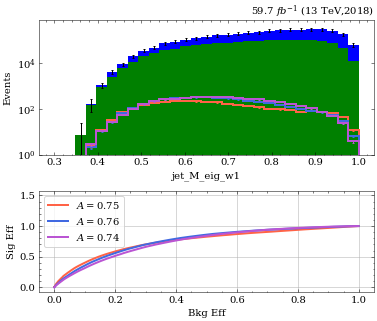

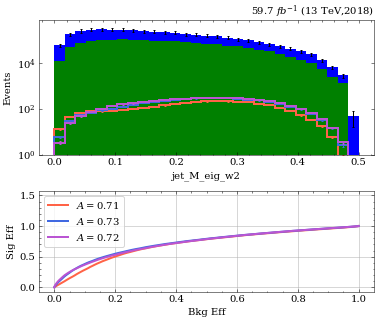

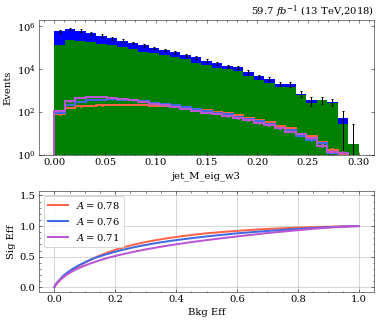

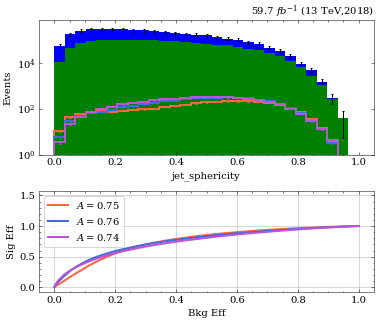

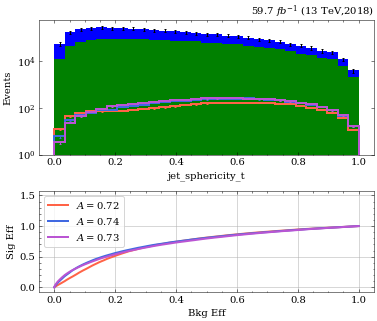

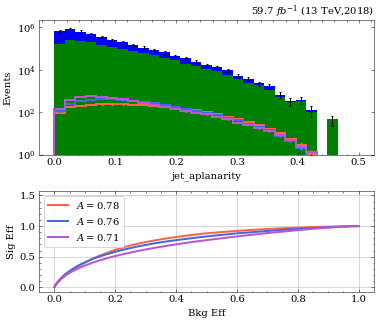

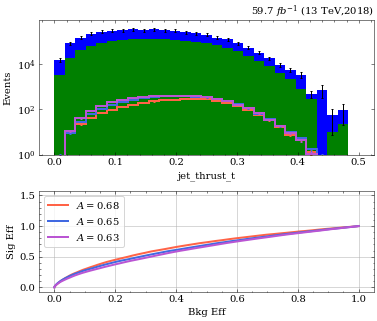

In [107]:
varlist = ["M_eig_w1","M_eig_w2","M_eig_w3","sphericity","sphericity_t","aplanarity","thrust_t","thrust_axis"]

study.table(
    signal+bkg, log=True,
    varlist=[f'jet_{var}' for var in varlist],
    ylim=(1,-1),
    **dict(study.auroc, e_c_ylabel='Sig Eff',e_c_xlabel='Bkg Eff'),
    e_c_store=obj_store(),
    tablef=table.add_auroc,
)

In [108]:
varinfo.higgs_m.update(xlabel=None,define='higgs mass ordered by pt')

100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


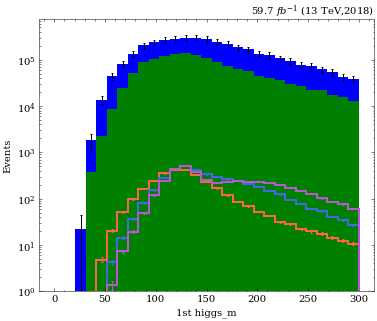

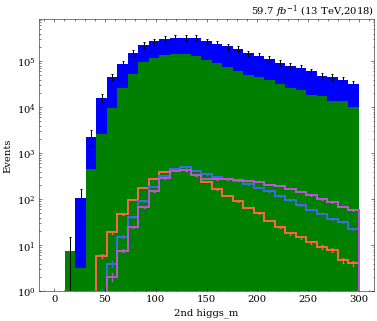

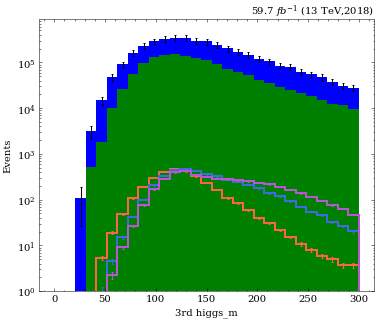

In [109]:
study.table(
    signal+bkg, log=True,
    varlist=[f'higgs_m[:,{i}]' for i in range(4)],
    ylim=(1,-1),
)

In [110]:
def ym_asym(t):
    ym_diff = t.Y1_m - t.Y2_m + 1e-3
    ym_sum  = t.Y1_m + t.Y2_m + 1e-3

    t.extend(ym_asym=(ym_diff/ym_sum))
(signal+bkg).apply(ym_asym)
def hm_asym(t):
    hm = t.higgs_m
    h1, h2 = ak.unzip(ak.combinations(hm, 2, axis=-1))
    hm_asym = (h1 - h2 + 1e-3)/(h1 + h2 + 1e-3)

    h1, h2 = ak.unzip(ak.combinations(np.arange(4)+1, 2, axis=0))

    t.extend(**{
        f'hm{j}{k}_asym':hm_asym[:,i]
        for i,(j,k) in enumerate(zip(h1, h2))
    })
(signal+bkg).apply(hm_asym)

[None, None, None, None, None]

In [111]:
varinfo.ym_asym = dict(bins=(0,1,30), define="(Y1_m - Y2_m)/(Y1_m + Y2_m)")

100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


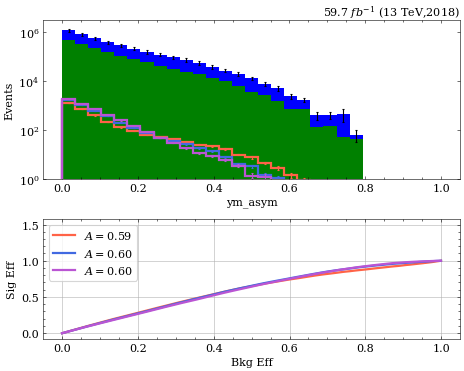

In [112]:
study.quick(
    signal+bkg, log=True,
    ylim=(1,-1),
    h_transform=np.abs,
    varlist=[f'ym_asym'],
    **dict(study.auroc, e_c_ylabel='Sig Eff',e_c_xlabel='Bkg Eff'),
)

In [113]:
for i in range(4):
    for j in range(i+1, 4):
        setattr(varinfo, f'hm{i+1}{j+1}_asym', dict(bins=(0,1,30), define=f"(h{i+1}_m-h{j+1}_m)/(h{i+1}_m+h{j+1}_m)"))

100%|██████████| 6/6 [00:04<00:00,  1.41it/s]


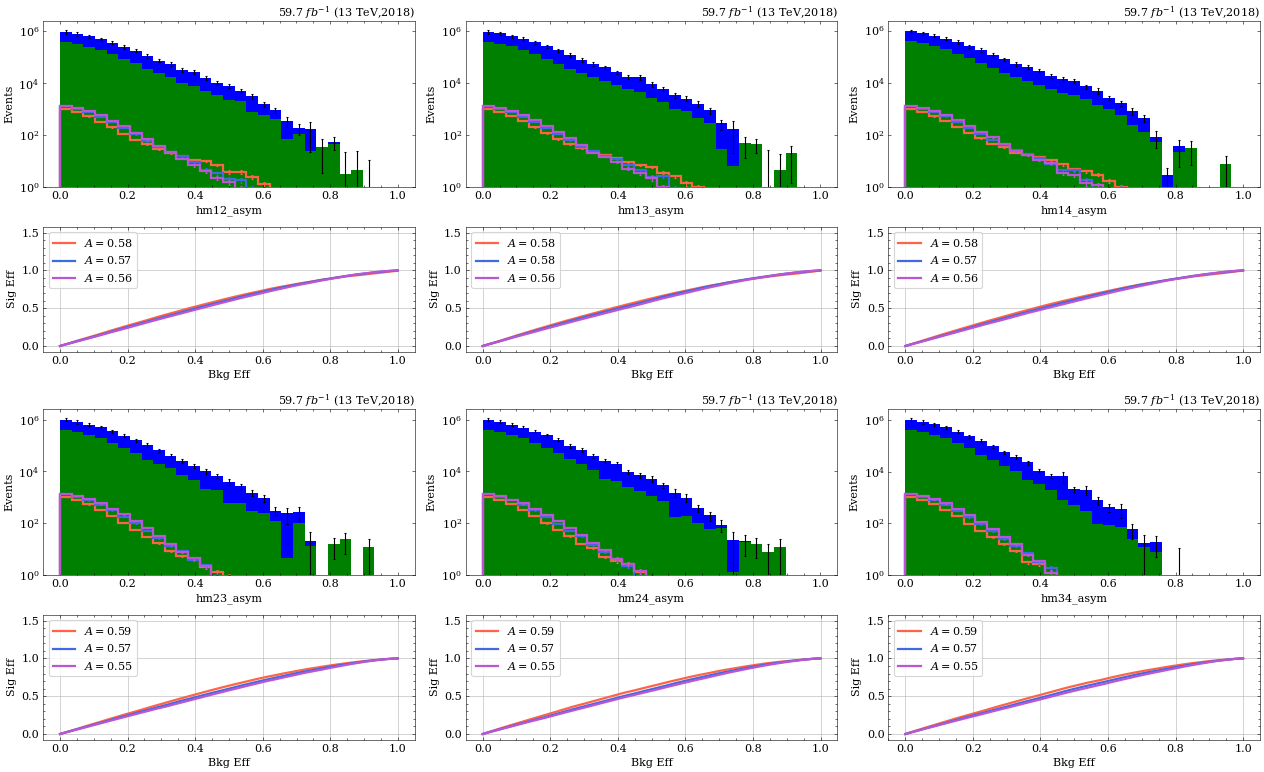

In [114]:
study.quick(
    signal+bkg, log=True,
    ylim=(1,-1),
    h_transform=np.abs,
    varlist=[f'hm{i+1}{j+1}_asym' for i in range(4) for j in range(i+1, 4)],
    **dict(study.auroc, e_c_ylabel='Sig Eff',e_c_xlabel='Bkg Eff'),
)

100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


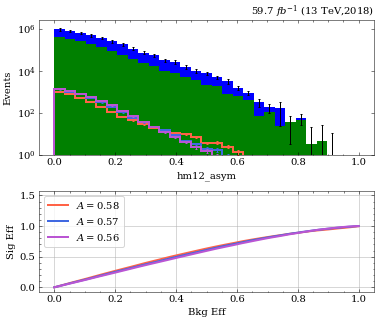

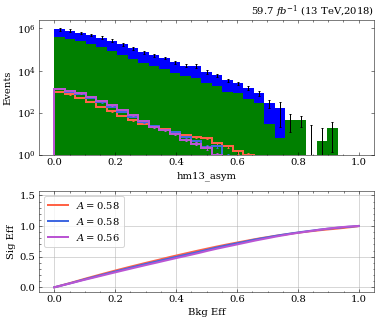

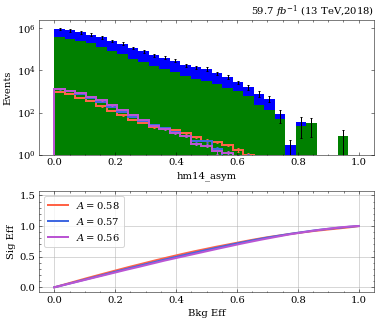

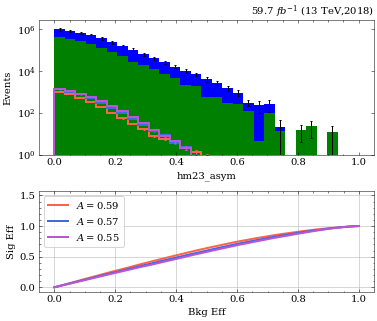

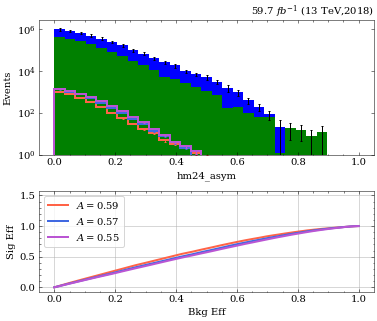

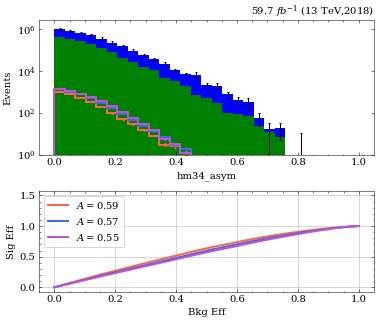

In [115]:
study.table(
    signal+bkg, log=True,
    h_transform=np.abs,
    varlist=[f'hm{i+1}{j+1}_asym' for i in range(4) for j in range(i+1, 4)]+['ym_asym'],
    ylim=(1,-1),
    **dict(study.auroc, e_c_ylabel='Sig Eff',e_c_xlabel='Bkg Eff'),
    e_c_store=obj_store(),
    table=table_csv,
    tablef=table.add_auroc,
)

In [116]:
varinfo.update(
    {
        f'n_{wplabel}_btag':dict(define=f'Number of {wplabel} btagged jets in selected 8 jets')
        for wplabel in wplabels[1:]
    }
)

100%|██████████| 3/3 [00:02<00:00,  1.11it/s]


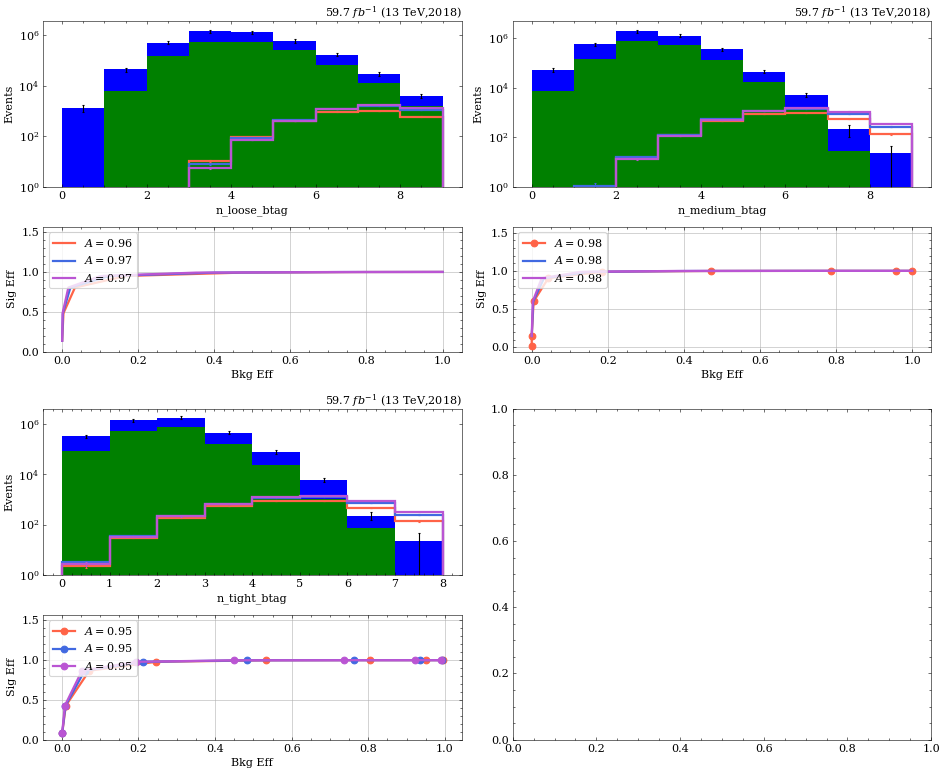

In [117]:
study.quick(
    signal+bkg, log=True,
    varlist=['n_loose_btag','n_medium_btag','n_tight_btag'],
    ylim=(1,-1),
    **dict(study.auroc, e_c_ylabel='Sig Eff',e_c_xlabel='Bkg Eff'),
    e_c_store=obj_store(),
    table=table_csv,
    tablef=table.add_auroc,
)

In [118]:
isinstance(obj_store(), obj_store)

True

100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


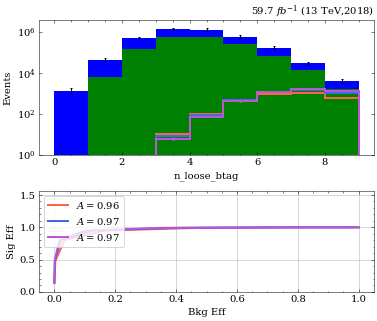

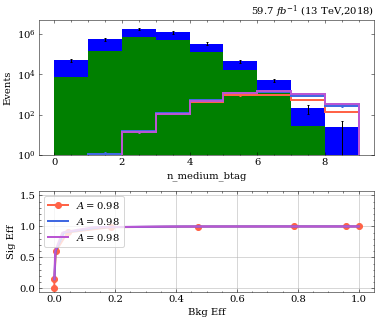

In [119]:
study.table(
    signal+bkg, log=True,
    varlist=['n_loose_btag','n_medium_btag','n_tight_btag'],
    ylim=(1,-1),
    **dict(study.auroc, e_c_ylabel='Sig Eff',e_c_xlabel='Bkg Eff'),
    e_c_store=obj_store(),
    table=table_csv,
    tablef=table.add_auroc,
)

In [120]:
def jet_ht(t):
    jet_ht = ak.sum(t.jet_ptRegressed, axis=-1)
    jet_htfrac = jet_ht/t.X_m
    t.extend(
        jet_ht=jet_ht,
        jet_htfrac=jet_htfrac
    )
(signal+bkg).apply(jet_ht)

[None, None, None, None, None]

In [121]:
varinfo.update(
    jet_ht=dict(define="Sum of the 8 selected jet Pt"),
    jet_htfrac=dict(define="jet_ht/X_m", bins=(0,2,30))
)

In [122]:
signal.jet_htfrac.apply(np.max)

[1.6917527, 1.6865851, 1.5196066]

In [123]:
varinfo.jet_htfrac.bins

(0, 2, 30)

100%|██████████| 2/2 [00:01<00:00,  1.91it/s]


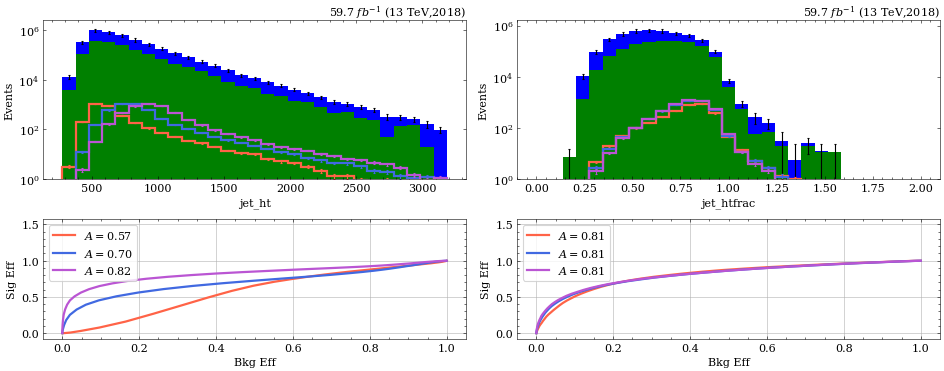

In [124]:
study.quick(
    signal+bkg, log=True,
    varlist=['jet_ht','jet_htfrac'],
    ylim=(1,-1),
    **dict(study.auroc, e_c_ylabel='Sig Eff',e_c_xlabel='Bkg Eff'),
    e_c_store=obj_store(),
    table=table_csv,
    tablef=table.add_auroc,
)

100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


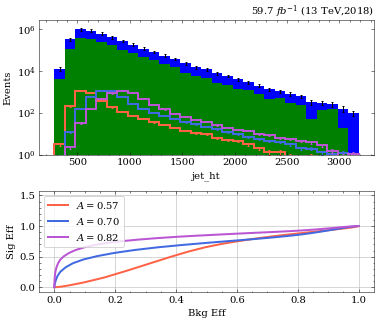

In [125]:
study.table(
    signal+bkg, log=True,
    varlist=['jet_ht','jet_htfrac'],
    ylim=(1,-1),
    **dict(study.auroc, e_c_ylabel='Sig Eff',e_c_xlabel='Bkg Eff'),
    e_c_store=obj_store(),
    table=table_csv,
    tablef=table.add_auroc,
)

100%|██████████| 2/2 [00:00<00:00,  4.26it/s]


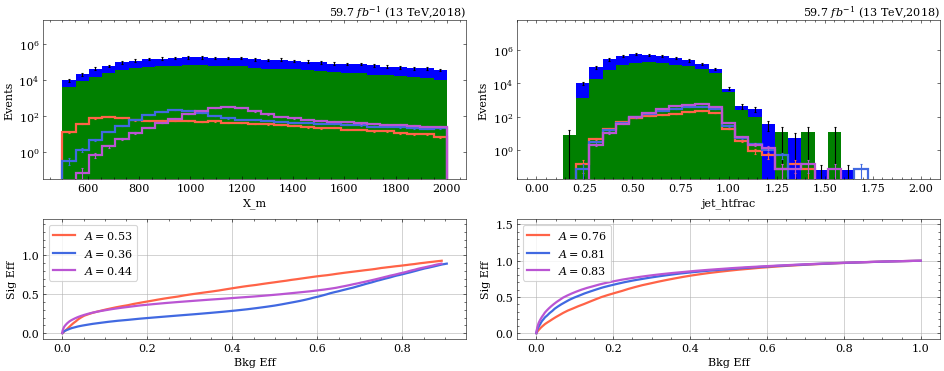

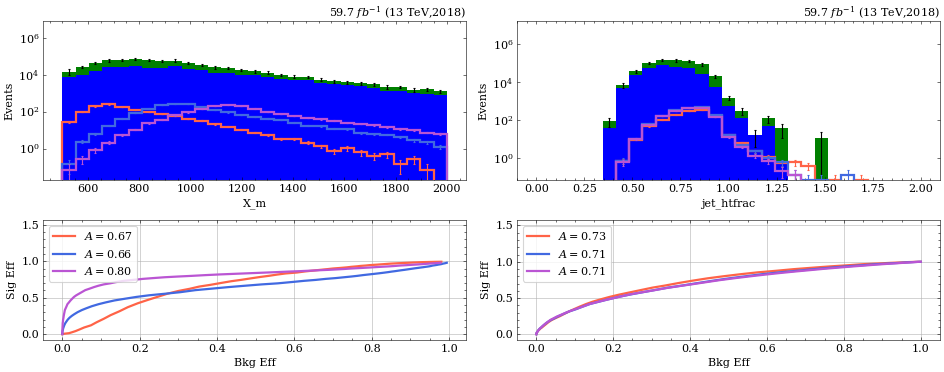

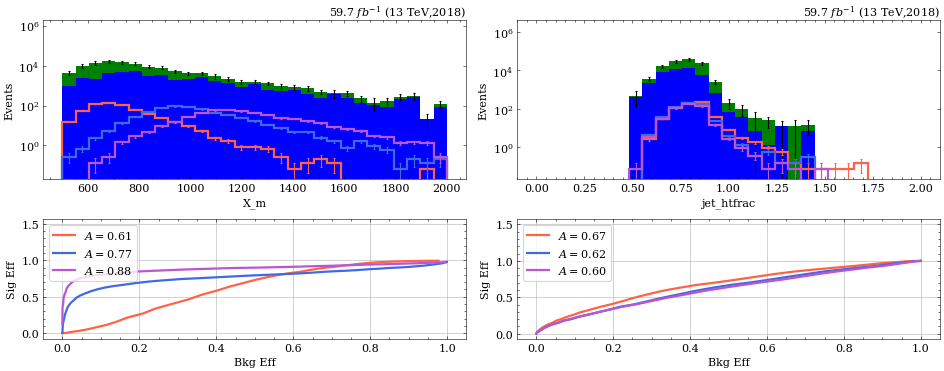

In [126]:
for lo,hi in ( (0,0.1),(0.1,0.2),(0.2,0.3) ):
    study.quick(
        signal+bkg, log=True,
        masks=lambda t : (t.jet_aplanarity>lo)&(t.jet_aplanarity<hi),
        varlist=['X_m','jet_htfrac'],
        **study.auroc,
    )